In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [5]:
#ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

In [6]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

Error, cannot find files in folder/scratch/pp2681/mom6/Apr2023/generalization/Yankovsky24-R8/ref/output


In [7]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [8]:
len(ds.exps)

1112

In [9]:
for exp in ds.exps:
    if 'GZ' in exp:
        print(exp)

GZ21-R4
GZ21-R5
GZ21-R6
GZ21-R7
GZ21-R8
R2_GZ-20YEAR_no_scaling
R3_GZ-20YEAR_no_scaling
R4_GZ-20YEAR
R4_GZ-20YEAR_no_scaling
R5_GZ-20YEAR
R5_GZ-20YEAR_no_scaling
R6_GZ-20YEAR
R6_GZ-20YEAR_no_scaling
R7_GZ-20YEAR
R7_GZ-20YEAR_no_scaling
R8_GZ-20YEAR
R8_GZ-20YEAR_no_scaling


In [10]:
for exp in ds.exps:
    if 'Yankovsky' in exp:
        print(exp)

Yankovsky24-R7-ref
Yankovsky24-0.06-R3-ref
Yankovsky24-R6-ref
Yankovsky24-0.06-R6-ref
Yankovsky24-R4-ref
Yankovsky24-0.06-R4-ref
Yankovsky24-0.06-R8-ref
Yankovsky24-R8-ref
Yankovsky24-0.06-R5-ref
Yankovsky24-R2-ref
Yankovsky24-0.06-R2-ref
Yankovsky24-0.06-R7-ref
Yankovsky24-R5-ref
Yankovsky24-R3-ref


In [11]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Generalization

In [12]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        sample.append(
            Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
        )
    return xr.DataArray(sample, dims='sample')

In [13]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [14]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        u = ds[exp].u.sel(Time=idx)
        v = ds[exp].v.sel(Time=idx)
        h = ds[exp].h.sel(Time=idx)

        KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
        #print(year_start)
        #print(KE.compute())
        sample.append(KE)
    return xr.DataArray(sample, dims='sample')

In [15]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [16]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        e = ds[exp].e.sel(Time=idx)
        APE = 1e-15 * (
            ds[exp].PE_joul(e).mean('Time').sum() + 
            ds[exp].PE_ssh(e).mean('Time').sum()
        )
        sample.append(APE)
    return xr.DataArray(sample, dims='sample')

In [17]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

In [18]:
%%time
error = {}
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh], ['KE','APE', 'ssh']):
    %time error[f'bare-{fun_str}'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'ZB-clean-{fun_str}'] = xr.concat([fun(f'ZB-clean-{conf}-ZB-0.4', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'ZB-Smooth-{fun_str}'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'ZB-Reynolds-{fun_str}'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'Jansen-Held-{fun_str}'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'GZ-{fun_str}'] = xr.concat([error[f'bare-{fun_str}'].isel(res=0)*np.nan, error[f'bare-{fun_str}'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'Yankovsky24-{fun_str}'] = xr.concat([fun(f'Yankovsky24-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7']], dim='res')
    %time error[f'Yankovsky24-0.06-{fun_str}'] = xr.concat([fun(f'Yankovsky24-0.06-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    print(fun_str+' Done')

CPU times: user 10.9 s, sys: 969 ms, total: 11.9 s
Wall time: 7.15 s
CPU times: user 12.1 s, sys: 1.46 s, total: 13.6 s
Wall time: 8.62 s
CPU times: user 12.2 s, sys: 1.4 s, total: 13.6 s
Wall time: 8.71 s
CPU times: user 12 s, sys: 1.29 s, total: 13.3 s
Wall time: 8.48 s
CPU times: user 12.2 s, sys: 1.36 s, total: 13.6 s
Wall time: 8.67 s
CPU times: user 9.98 s, sys: 1.12 s, total: 11.1 s
Wall time: 6.74 s
CPU times: user 9.47 s, sys: 1 s, total: 10.5 s
Wall time: 7.07 s
CPU times: user 12.3 s, sys: 1.27 s, total: 13.5 s
Wall time: 8.9 s
KE Done
CPU times: user 3.03 s, sys: 377 ms, total: 3.41 s
Wall time: 7.91 s
CPU times: user 3.38 s, sys: 340 ms, total: 3.72 s
Wall time: 7.46 s
CPU times: user 3.04 s, sys: 374 ms, total: 3.41 s
Wall time: 7.55 s
CPU times: user 3.05 s, sys: 369 ms, total: 3.42 s
Wall time: 7.57 s
CPU times: user 3.05 s, sys: 361 ms, total: 3.41 s
Wall time: 7.06 s
CPU times: user 2.47 s, sys: 317 ms, total: 2.79 s
Wall time: 6.27 s
CPU times: user 2.49 s, sys: 289 

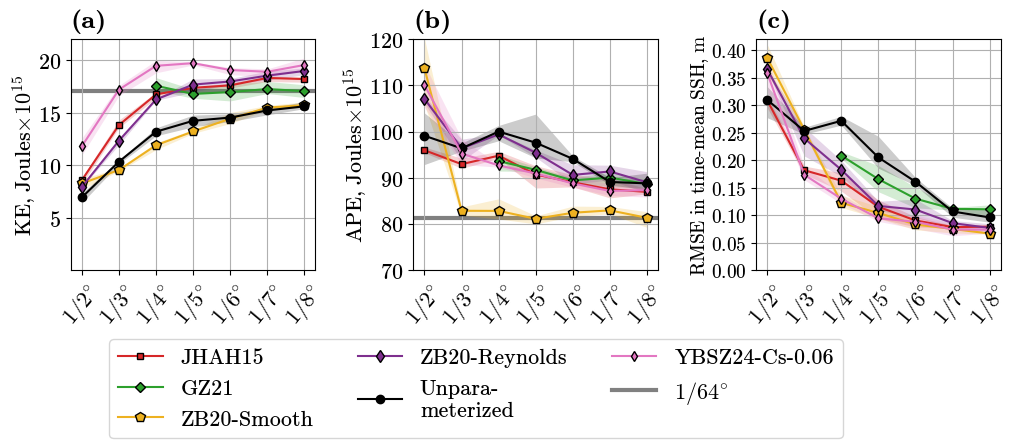

In [41]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, (fun, fun_str) in enumerate(zip([sample_KE, sample_APE, sample_ssh], ['KE','APE', 'ssh'])):
    plt.subplot(1,3,row+1)
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None):
        e = error[f'{model}-{fun_str}']
        e.mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k')
        plt.fill_between(range(len(e.isel(sample=0))), error[f'{model}-{fun_str}'].min('sample'), error[f'{model}-{fun_str}'].max('sample'), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JHAH15', 5)
    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    #plot_markers_with_filling('Yankovsky24', 'tab:pink', 'd',  'YBSZ24-Cs-0.2', 7)
    plot_markers_with_filling('Yankovsky24-0.06', 'tab:pink', 'd', 'YBSZ24-Cs-0.06', 5)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([0,22])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, $\mathrm{m}$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.savefig('Review-3/Metrics-all-Yankovsky-Cs-0.06.pdf')

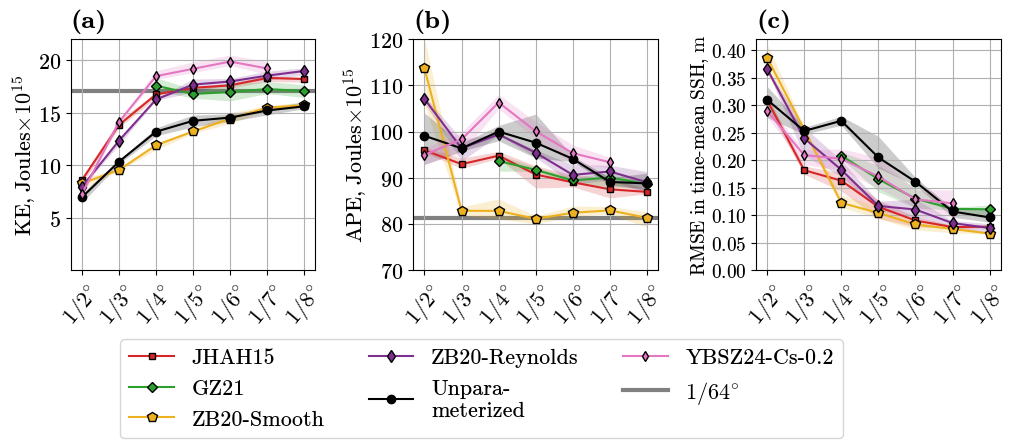

In [42]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, (fun, fun_str) in enumerate(zip([sample_KE, sample_APE, sample_ssh], ['KE','APE', 'ssh'])):
    plt.subplot(1,3,row+1)
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None):
        e = error[f'{model}-{fun_str}']
        e.mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k')
        plt.fill_between(range(len(e.isel(sample=0))), error[f'{model}-{fun_str}'].min('sample'), error[f'{model}-{fun_str}'].max('sample'), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JHAH15', 5)
    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    plot_markers_with_filling('Yankovsky24', 'tab:pink', 'd',  'YBSZ24-Cs-0.2', 5)
    #plot_markers_with_filling('Yankovsky24-0.06', 'tab:pink', 'd', 'YBSZ24-Cs-0.06', 9)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([0,22])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, $\mathrm{m}$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.savefig('Review-3/Metrics-all-Yankovsky.pdf')

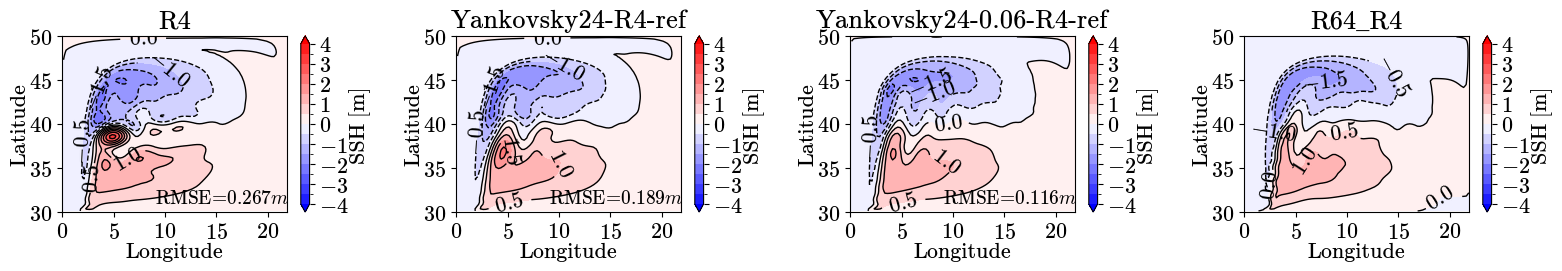

In [40]:
ds.plot_ssh(['R4','Yankovsky24-R4-ref', 'Yankovsky24-0.06-R4-ref', 'R64_R4'])

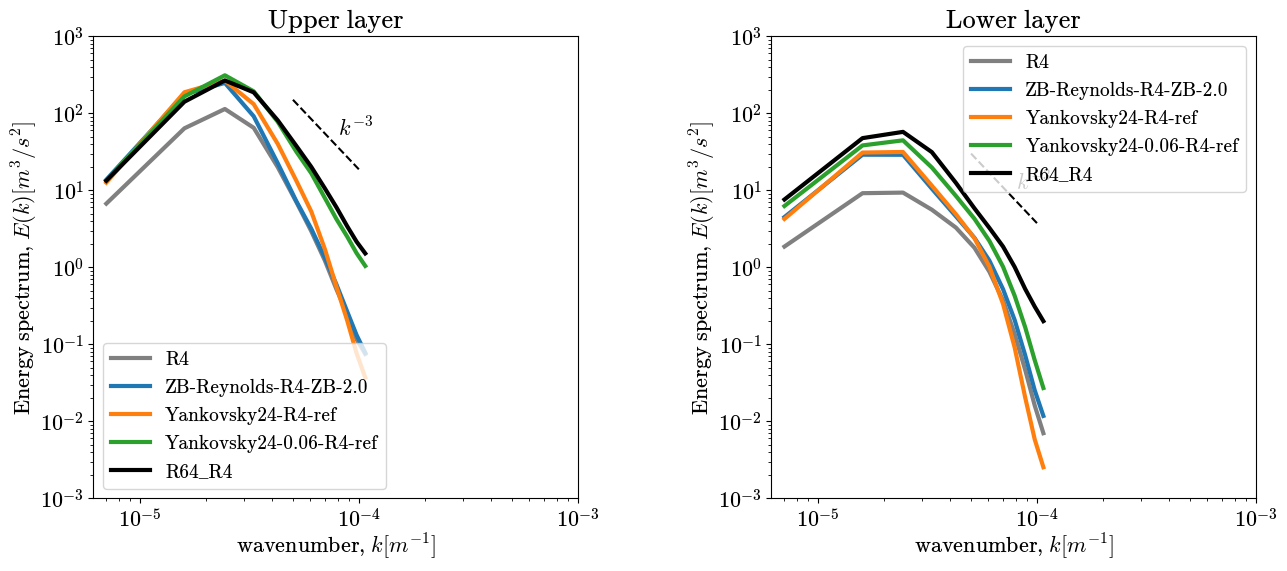

In [46]:
ds.plot_KE_spectrum(['R4','ZB-Reynolds-R4-ZB-2.0', 'Yankovsky24-R4-ref', 'Yankovsky24-0.06-R4-ref', 'R64_R4'])

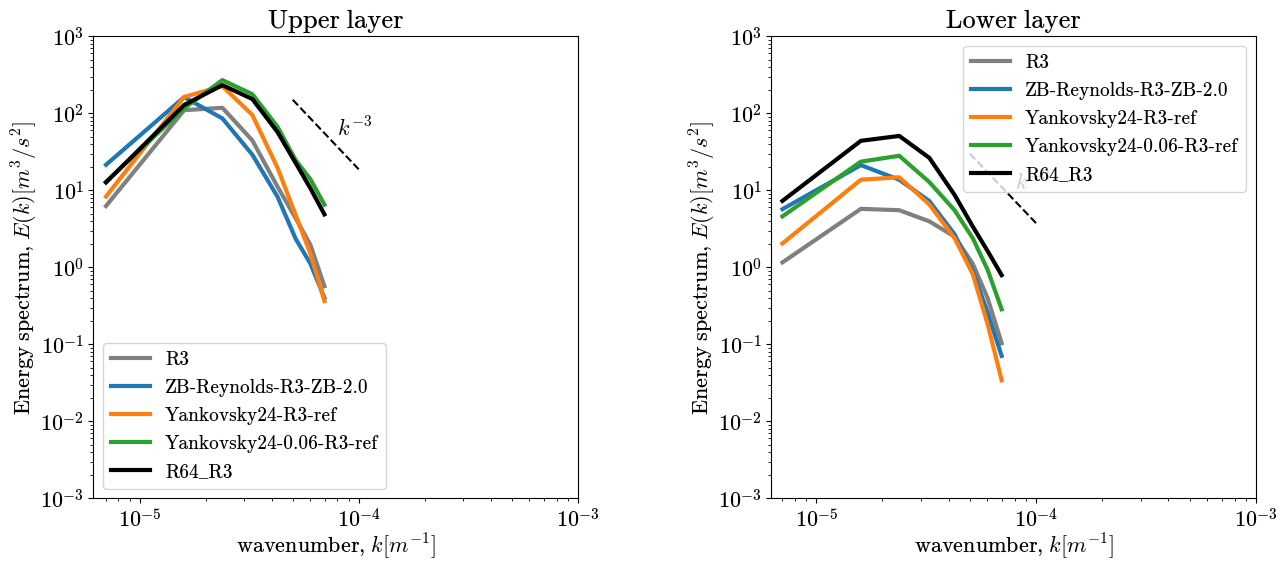

In [47]:
ds.plot_KE_spectrum(['R3','ZB-Reynolds-R3-ZB-2.0', 'Yankovsky24-R3-ref', 'Yankovsky24-0.06-R3-ref', 'R64_R3'])

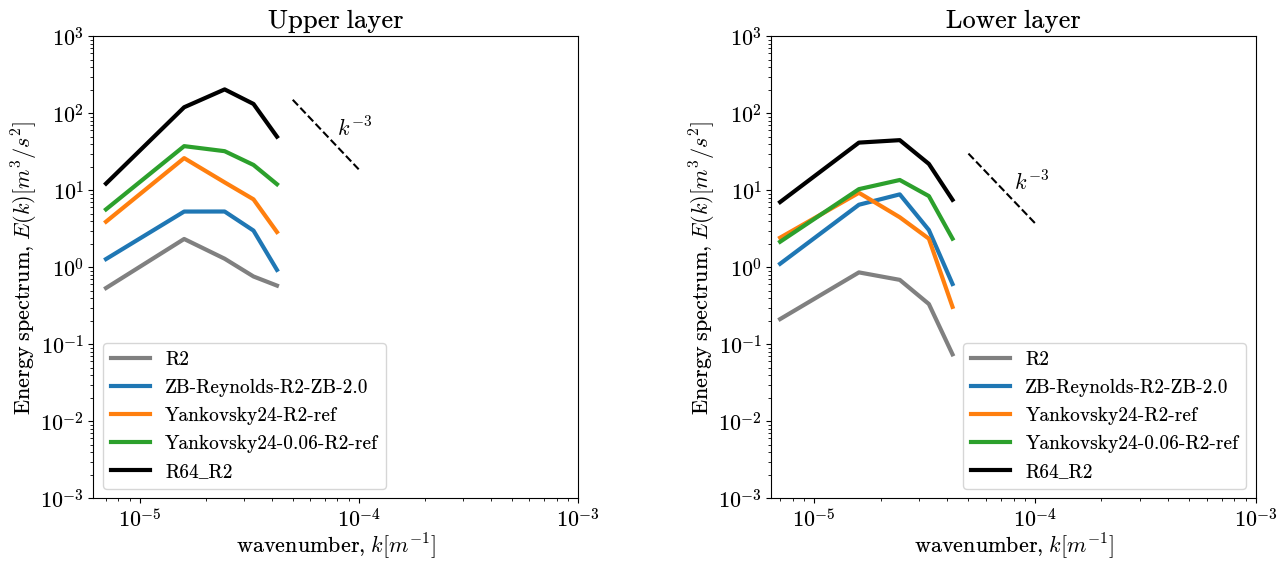

In [49]:
ds.plot_KE_spectrum(['R2','ZB-Reynolds-R2-ZB-2.0', 'Yankovsky24-R2-ref', 'Yankovsky24-0.06-R2-ref', 'R64_R2'])

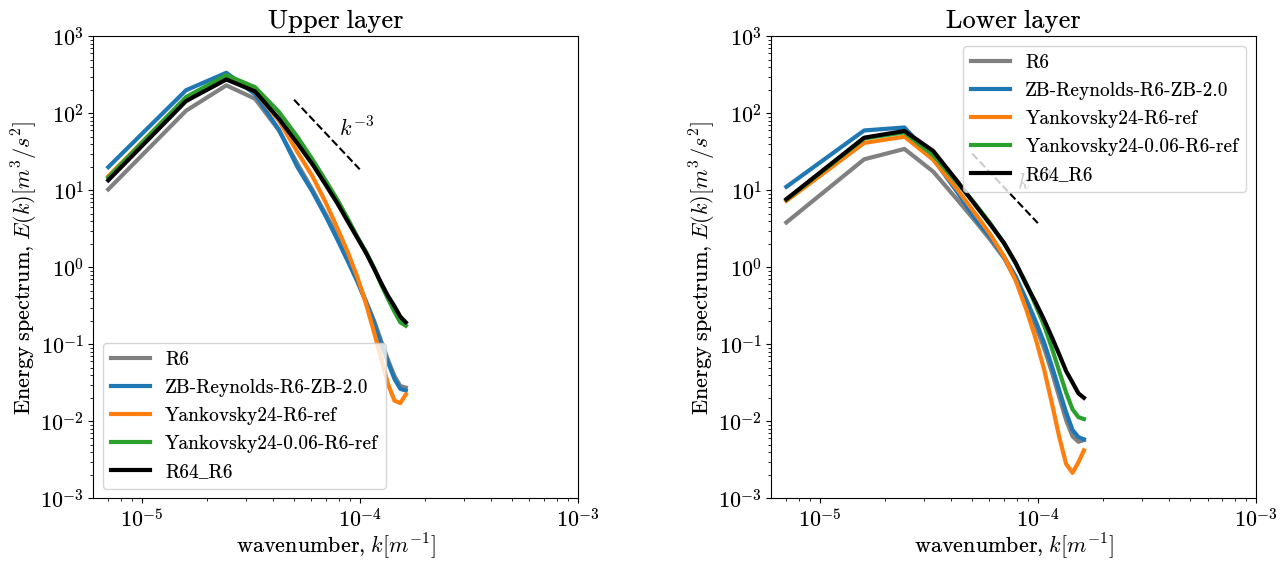

In [48]:
ds.plot_KE_spectrum(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'])

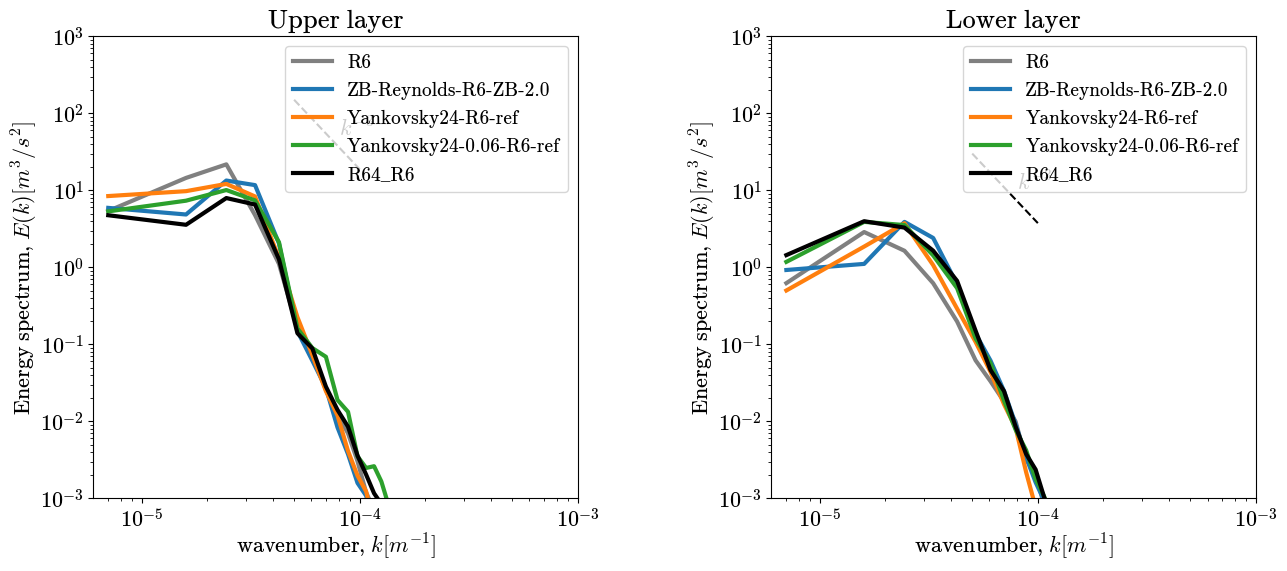

In [51]:
ds.plot_KE_spectrum(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'], key='MKE_spectrum')

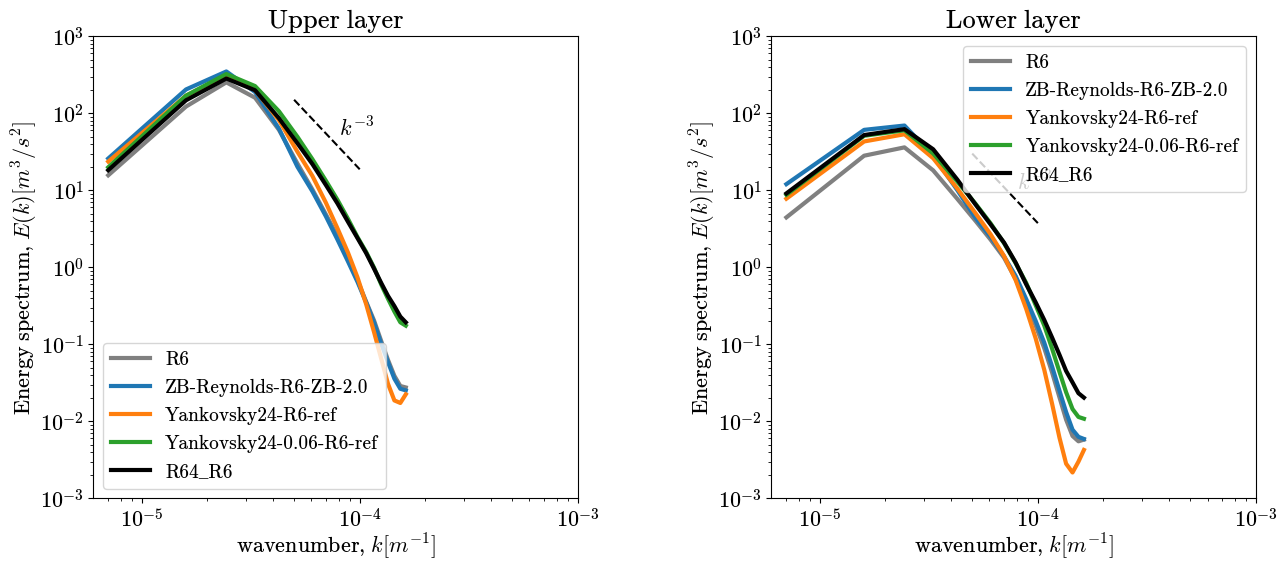

In [52]:
ds.plot_KE_spectrum(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'], key='KE_spectrum')

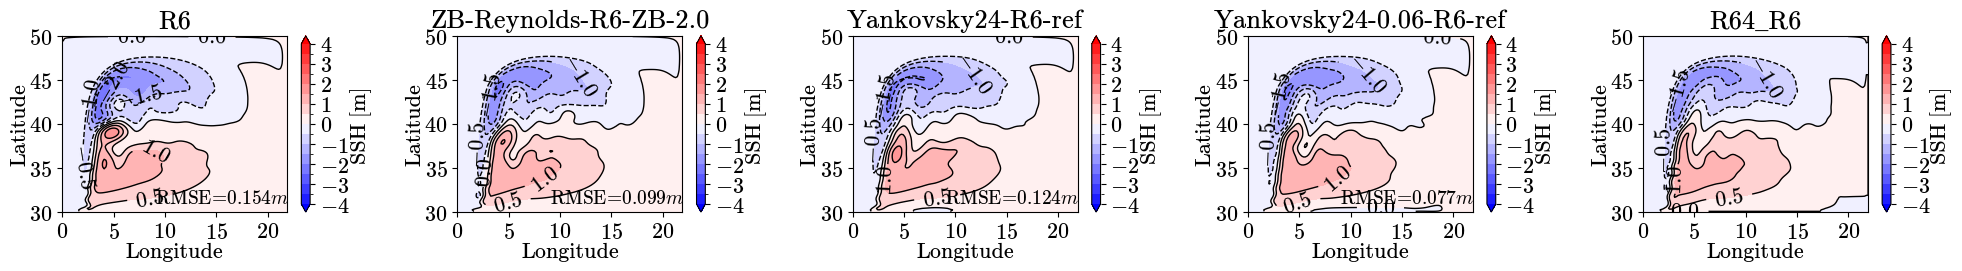

In [54]:
ds.plot_ssh(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'])

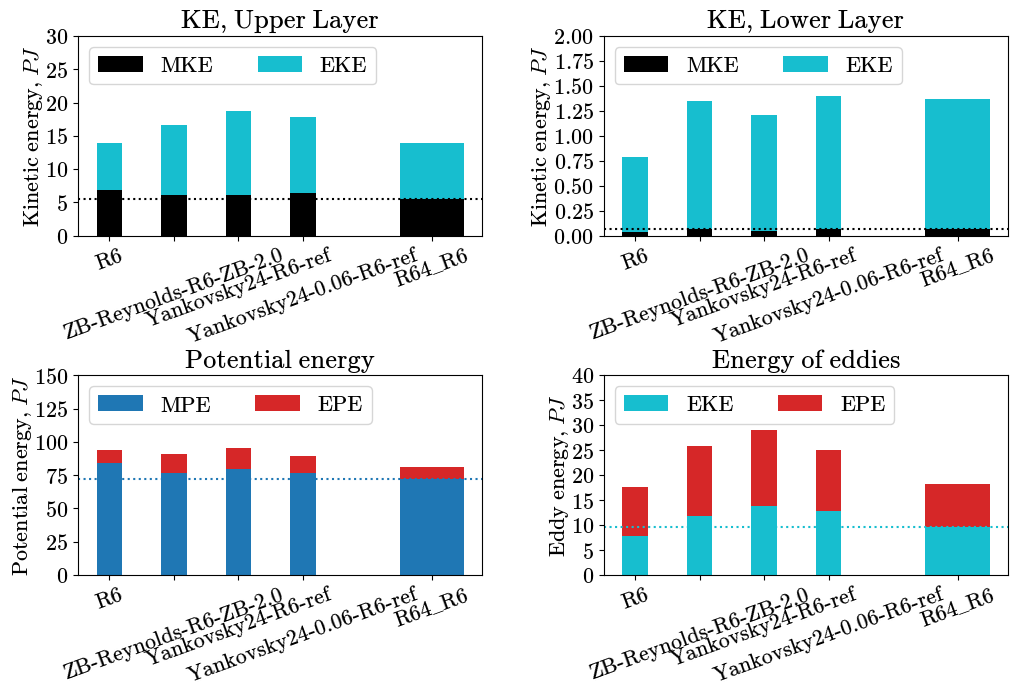

In [50]:
ds.plot_KE_PE(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'])

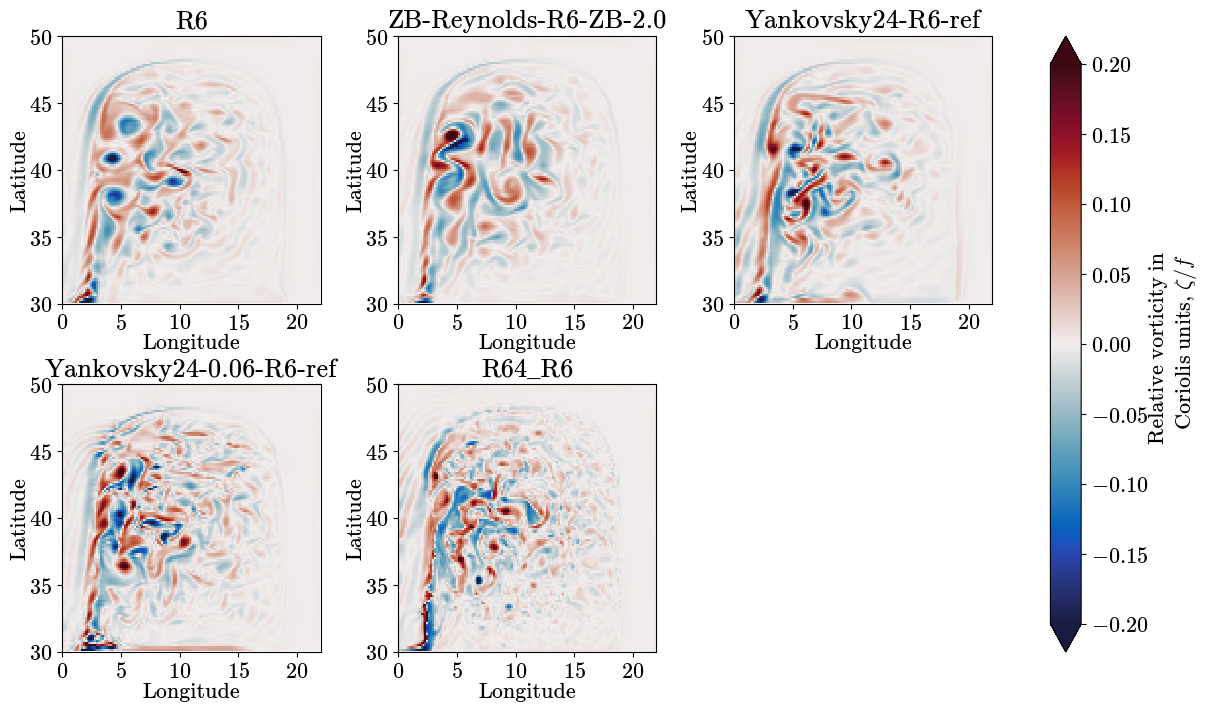

In [55]:
ds.plot_RV(['R6','ZB-Reynolds-R6-ZB-2.0', 'Yankovsky24-R6-ref', 'Yankovsky24-0.06-R6-ref', 'R64_R6'])

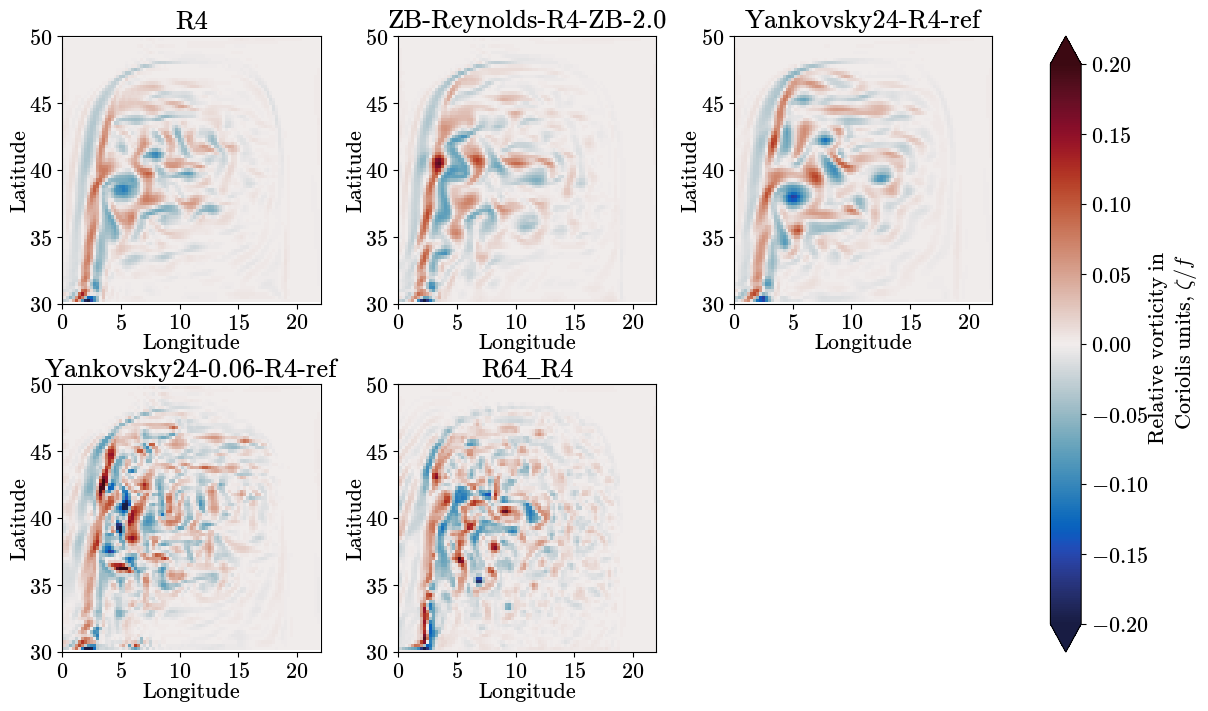

In [56]:
ds.plot_RV(['R4','ZB-Reynolds-R4-ZB-2.0', 'Yankovsky24-R4-ref', 'Yankovsky24-0.06-R4-ref', 'R64_R4'])

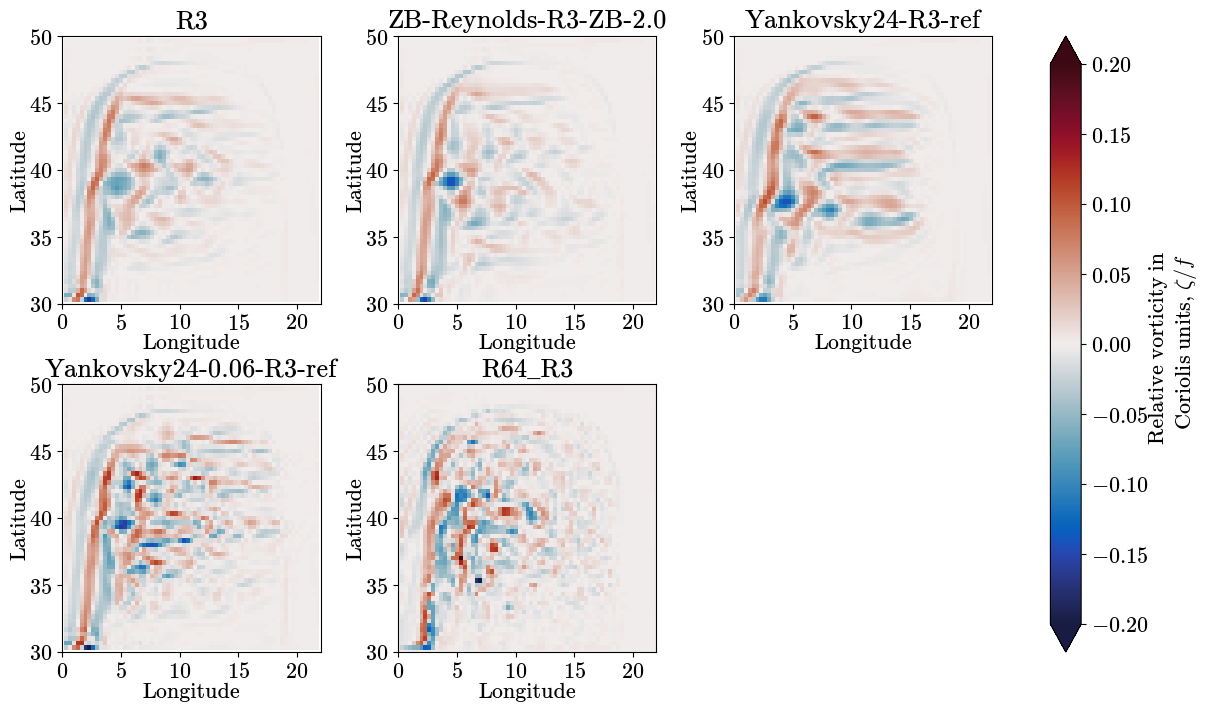

In [57]:
ds.plot_RV(['R3','ZB-Reynolds-R3-ZB-2.0', 'Yankovsky24-R3-ref', 'Yankovsky24-0.06-R3-ref', 'R64_R3'])

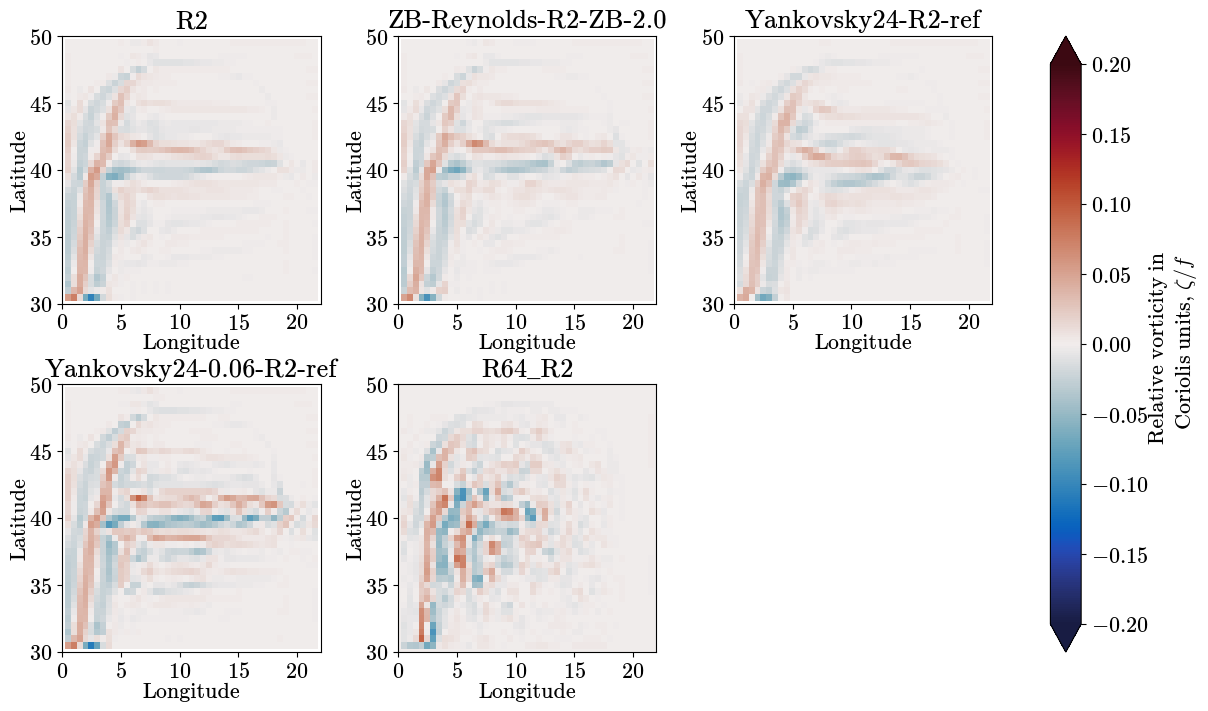

In [58]:
ds.plot_RV(['R2','ZB-Reynolds-R2-ZB-2.0', 'Yankovsky24-R2-ref', 'Yankovsky24-0.06-R2-ref', 'R64_R2'])

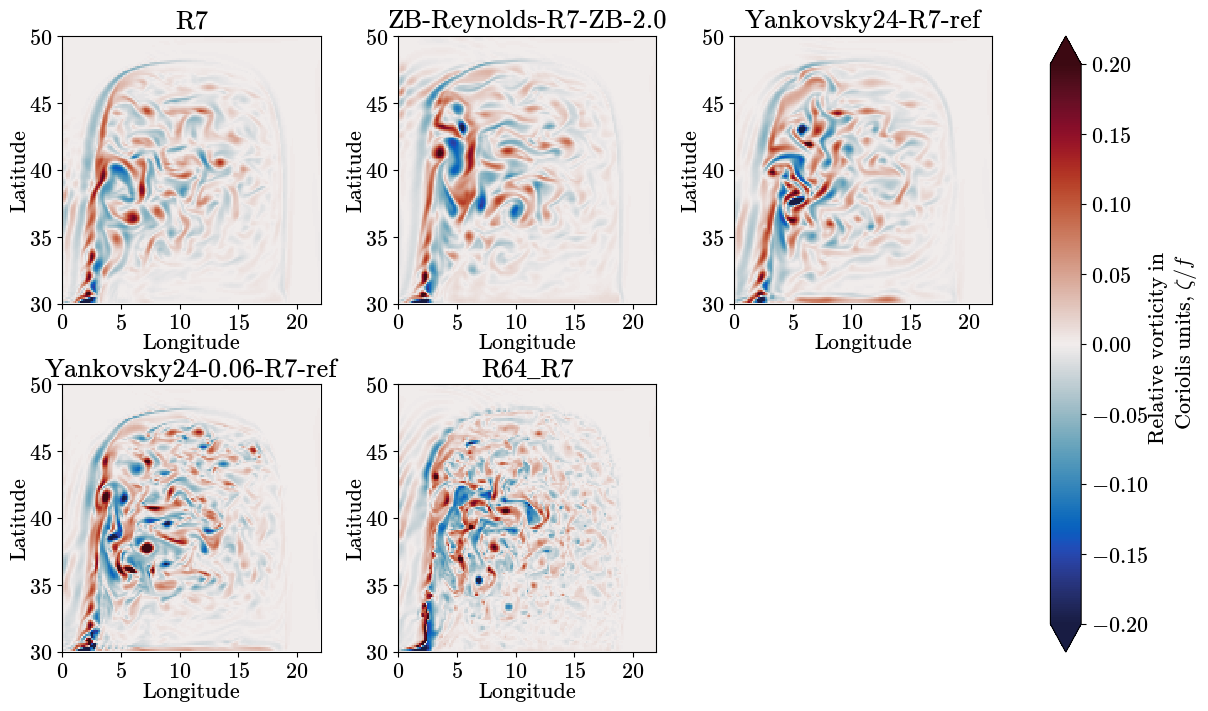

In [59]:
ds.plot_RV(['R7','ZB-Reynolds-R7-ZB-2.0', 'Yankovsky24-R7-ref', 'Yankovsky24-0.06-R7-ref', 'R64_R7'])

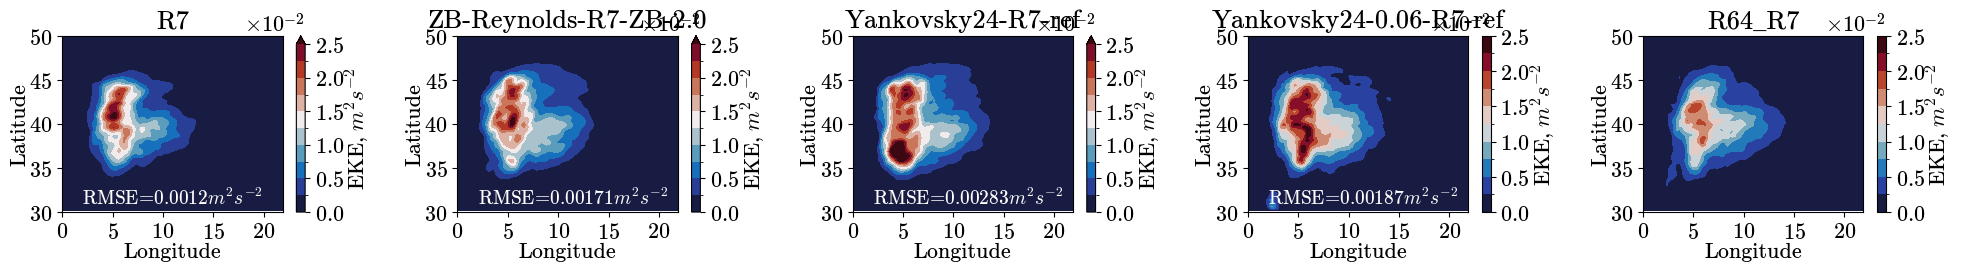

In [61]:
ds.plot_EKE(['R7','ZB-Reynolds-R7-ZB-2.0', 'Yankovsky24-R7-ref', 'Yankovsky24-0.06-R7-ref', 'R64_R7'])

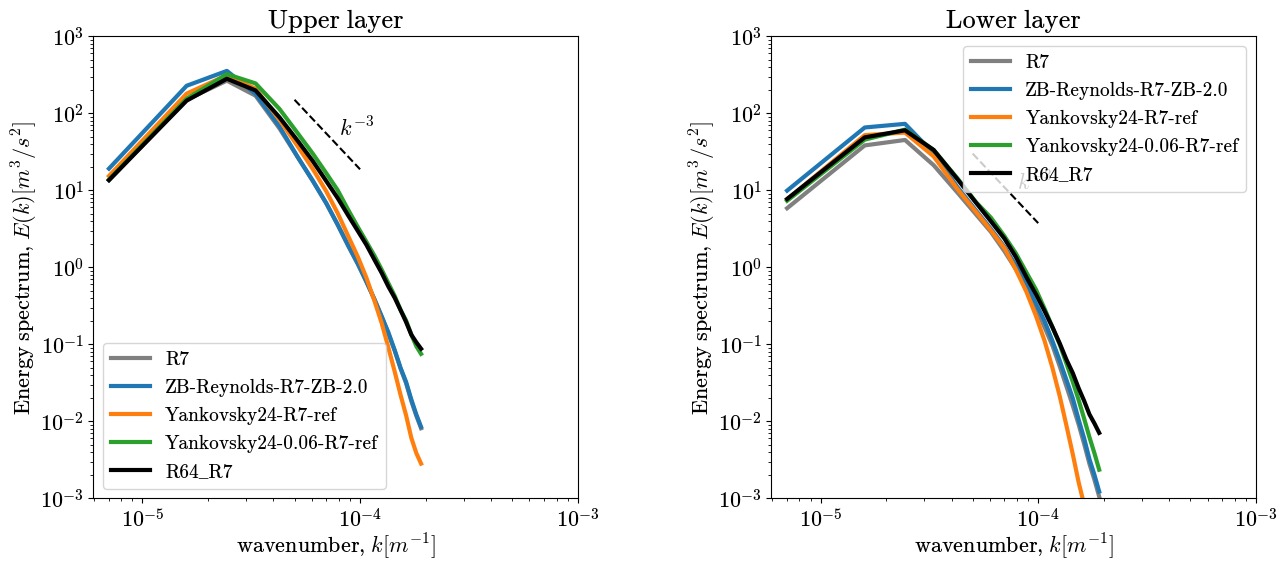

In [63]:
ds.plot_KE_spectrum(['R7','ZB-Reynolds-R7-ZB-2.0', 'Yankovsky24-R7-ref', 'Yankovsky24-0.06-R7-ref', 'R64_R7'])